# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Advanced-Sections: Homework 1 - Transfer Learning




**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
import os
import pathlib
working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
#print(working_dir)
os.chdir(working_dir)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit. (Exception - you may skip the cells where you train neural networks, running the cells which load previously saved weights instead. However, **don't delete/overwrite the output that model.fit produced during training!**)

**Names of person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os
# For colab: Import the TF V2 through this magic command
# %tensorflow_version 2.x 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

#import keras
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image

# Check the Version of the Tensor Flow. It should be the version 2
print(tf.__version__)

2.1.0


<div class="theme"> Overview </div> 


**How to use existing models for transfer learning:**
Transfer learning is a Machine Learning method where we use the knowledge gained while solving a problem to solve another problem. For instance, when the training data is too small to train a deep network, we can load a pre-trained network and then fine-tuning a few of its parameters by using our small training set.
In this homework you will be engaged with two usefull applications of transfer learning. (a) Train a deep network with a small dataset. (b) Improve the feature extraction of a pre-train deep network. In particular, the aim of the homework is:
- Learn the idea of transfer learning through a simple classification example
- Build  new networks by using pre-trained models. Combine  pre-trained layers with new layers, and train specific layers.
- Get good  performance of image classification and feature extraction by training with small datasets.


The task of this homework is to design a network for classifying and extracting features for two different categories:  dogs and flowers.  The pre-trained model that  will be used is the *MobileNet* which is trained in 1000 categories with 1000 images per category. Although this pre-trained model classifies and extract features from 1000 categories pretty well, there are some other categories that the pre-trained MobileNet does not perform very well. In this homework, we will improve the performance, namely the classification and the feature extraction abilities of the MobileNet on those categories. 

----------


<div class='exercise'><b> Question 1: Load and inspect the pre-trained MobileNet  [40pts total] </b></div>


In this question, we have to load the pre-trained MobileNet. Then use the images and perform some classifications. Check whether the MobileNet classifies well or not. Afterwards, you need to make a deeper investigation. In particular, explore the feature maps extracted by the MobileNet. In this task you need to use the Principal Component Analysis method (PCA) to visualize the abstract feature maps space. 

**1.1. [10pts]**  Load a pre-trained MobileNet and inspect its performance in some of the images from the given `trainData`, or `testData`, or `pcaData` sets (these are new data for the pretrained MobileNet). Is the performance similar for all the  categories?


Set the directory where the dataset are located with the name `pathFolder`

In [3]:
pathFolder='data/' # We set it to data so we can easily access the different datasets

Check that the pathFolder is correct by showing the following image

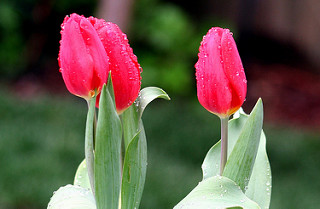

In [4]:
Image(filename= pathFolder + 'trainData/tulips/100930342_92e8746431_n.jpg')

Load the pre-train MobileNet trained in the `imagenet` dataset

In [5]:
# Load Mobile net
mobile = keras.applications.mobilenet.MobileNet()
mobile = MobileNet(weights='imagenet',include_top=True)

Inspect the MobileNet architecture and define the image size as `IMG_SIZE` and the input shape as `IMG_SHAPE`

In [6]:
# Define image size and shape
IMG_SIZE = mobile.input.shape[1]
IMG_SHAPE = (mobile.input.shape[1], mobile.input.shape[2], mobile.input.shape[3])
print('IMG_SIZE: {} \nIMG_SHAPE: {}'.format(IMG_SIZE, IMG_SHAPE))

IMG_SIZE: 224 
IMG_SHAPE: (224, 224, 3)


In [7]:
# Inspect MobileNet architecture
print("Check the input of MobileNet: ",mobile.input)
print("Check the output of MobileNet:",mobile.output)
mobile.summary()

Check the input of MobileNet:  Tensor("input_2:0", shape=(None, 224, 224, 3), dtype=float32)
Check the output of MobileNet: Tensor("act_softmax_1/Identity:0", shape=(None, 1000), dtype=float32)
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
____________________________________________________

**Three helper functions**

`prepare_image`: A function to prepare the images for the MobileNet. Input shape: (1, 224, 224, 3)

In [8]:
def prepare_image(img_path, img_size = 224):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

`mobileClassifier`: A helper function for doing the classification by using MobileNet

In [9]:
def mobileClassifier(imagePath, pathFolder=pathFolder, mobile=mobile):
    imagePathFull = pathFolder + imagePath
    preprocessed_image = prepare_image(imagePathFull)
    # Use mobileNet to classify the image
    predictions = mobile.predict(preprocessed_image)
    results = imagenet_utils.decode_predictions(predictions)
#     print(results)
    return results

`Prepare the data`

Load the data into the ImageDataGenerator. You might want to use  data augmentation:

 https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/ 


In [10]:
# this is a function to avoid reading secret directory. You might also need it later
filter_hidden = lambda my_list: [x for x in my_list if not x.startswith('.')]


train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                                 horizontal_flip=True, 
                                                 rotation_range=45, 
#                                                 zoom_range=[0.8,1.0]
                                ) 

test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

# TRAINING set
pathTrain = pathFolder + 'trainData/'
listGroupsTrain = filter_hidden(os.listdir(pathTrain)) # the directory path

# TESTING set
pathTest = pathFolder + 'testData/'
listGroupsTest = filter_hidden(os.listdir(pathTest)) # the directory path

# Load the data into the ImageDataGenerator
train_generator=train_datagen.flow_from_directory(pathTrain,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True, 
                                                 classes=listGroupsTrain)

test_generator=test_datagen.flow_from_directory(pathTest,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 classes=listGroupsTest)

Found 843 images belonging to 5 classes.
Found 160 images belonging to 5 classes.


Classify some of the images. Choose images from different categories

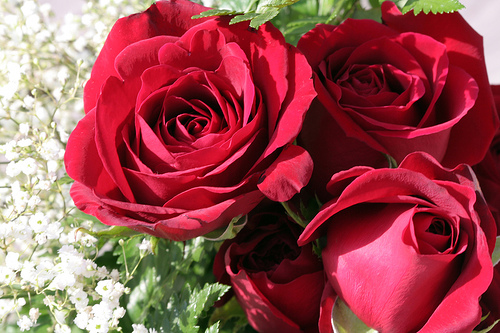

[[('n03724870', 'mask', 0.7167787),
  ('n02807133', 'bathing_cap', 0.10288635),
  ('n07718747', 'artichoke', 0.05384742),
  ('n03590841', "jack-o'-lantern", 0.028627621),
  ('n03045698', 'cloak', 0.013171888)]]

In [11]:
# Image of a rose
display(Image(filename= pathTrain + 'rose/568715474_bdb64ccc32.jpg', width=200))
display(mobileClassifier('rose/568715474_bdb64ccc32.jpg', pathFolder=pathTrain, mobile=mobile))

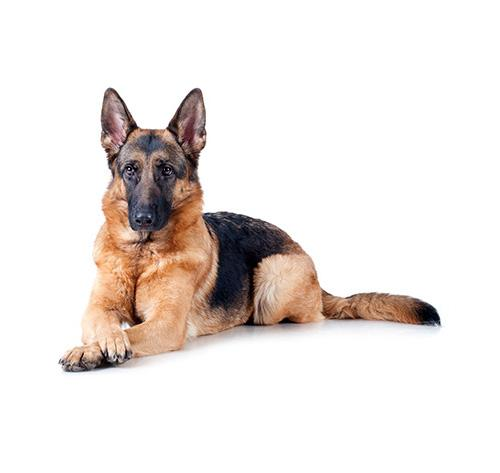

[[('n02106662', 'German_shepherd', 0.97057813),
  ('n02105162', 'malinois', 0.027501374),
  ('n02091467', 'Norwegian_elkhound', 0.00038259182),
  ('n02105251', 'briard', 0.00027124392),
  ('n02088466', 'bloodhound', 0.00023106748)]]

In [12]:
# Image of a German Shepard
display(Image(filename= pathTrain + 'German_Shepherd/35.german_shepherd.jpg', width=200))
display(mobileClassifier('German_Shepherd/35.german_shepherd.jpg', pathFolder=pathTrain, mobile=mobile))

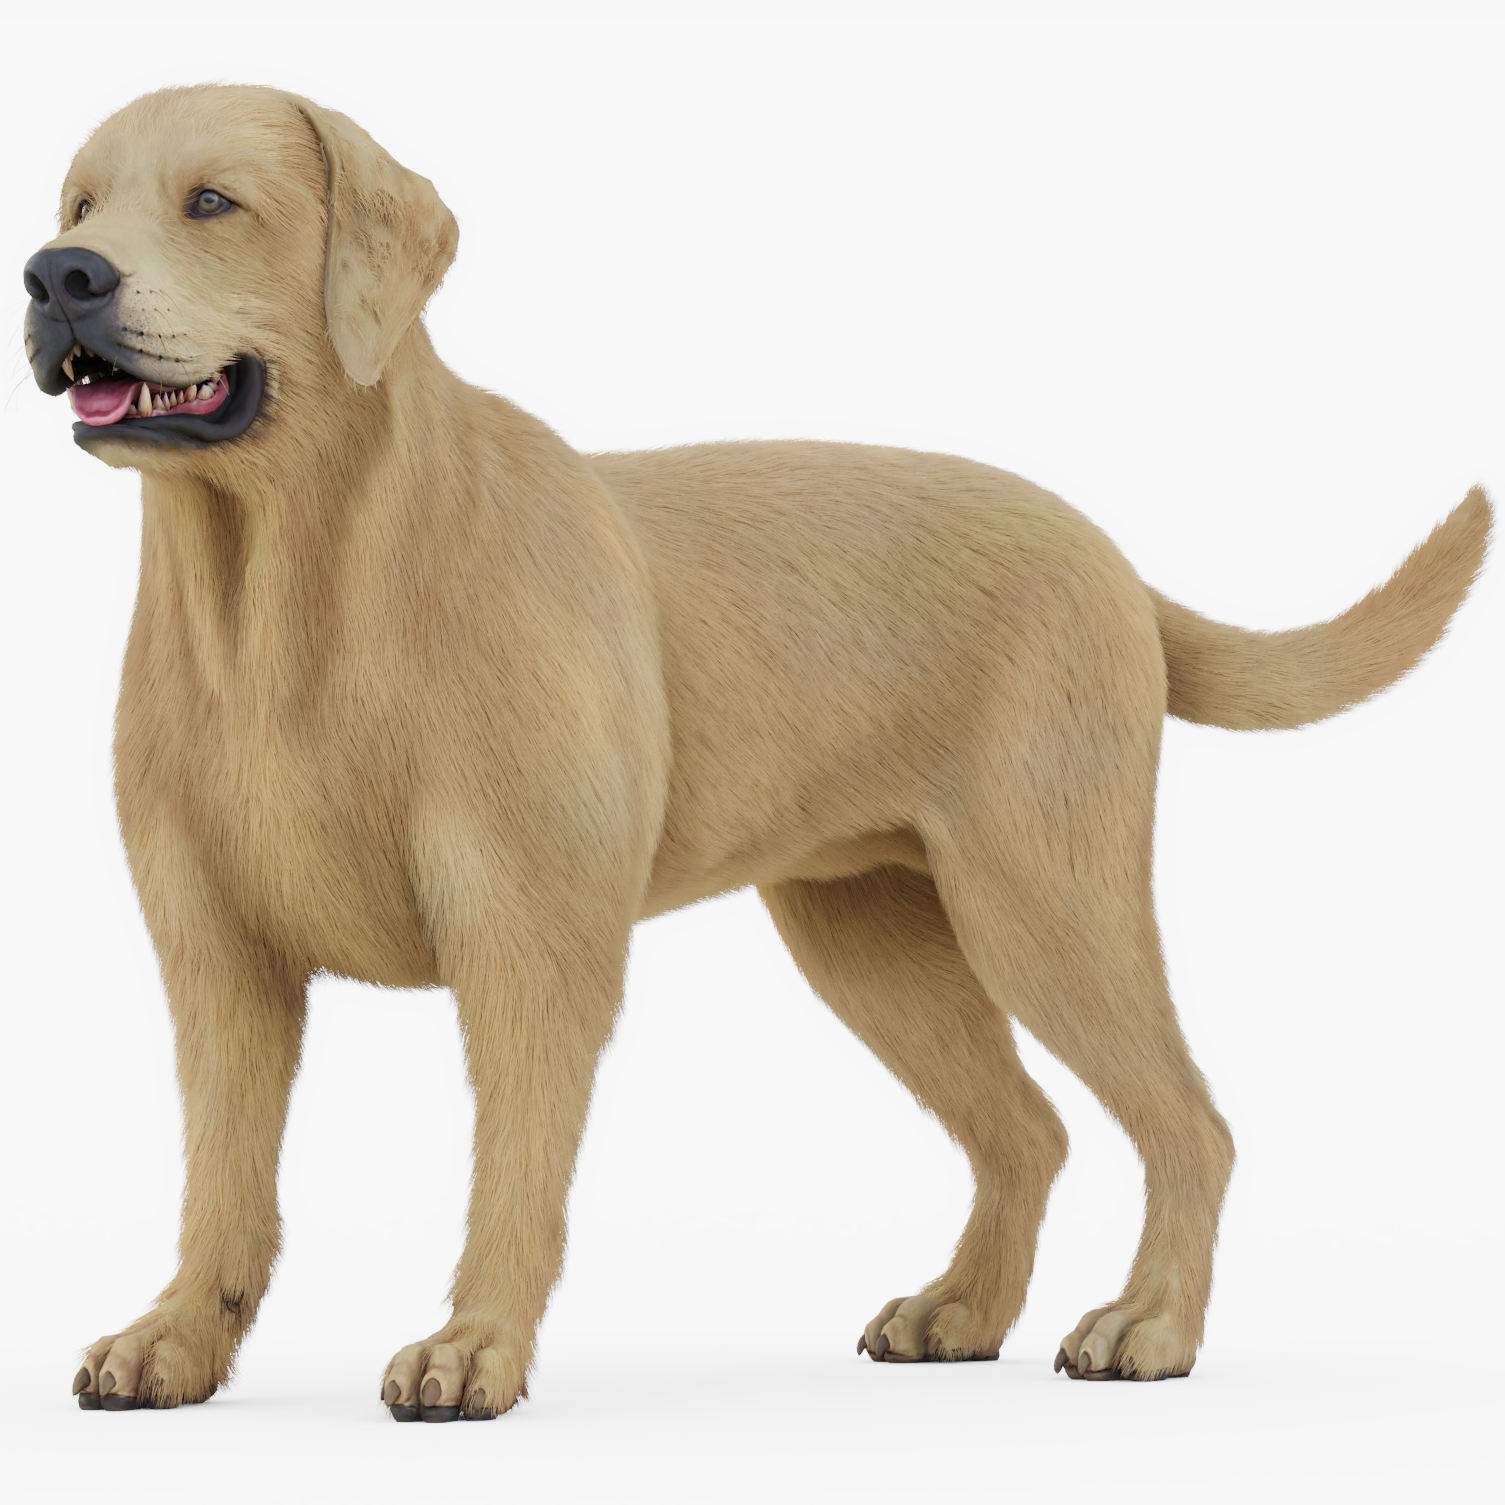

[[('n02099712', 'Labrador_retriever', 0.36500588),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.10165314),
  ('n02100583', 'vizsla', 0.09884945),
  ('n02090379', 'redbone', 0.09543356),
  ('n02099601', 'golden_retriever', 0.08611022)]]

In [13]:
# Image of a Labrador retriever
display(Image(filename= pathTrain + 'labrador/9.Thumbnail_0.pngDB254E7E-379C-40AF-A29E-74C162CFDF37Zoom.jpg', width=200))
display(mobileClassifier('labrador/9.Thumbnail_0.pngDB254E7E-379C-40AF-A29E-74C162CFDF37Zoom.jpg', pathFolder=pathTrain, mobile=mobile))

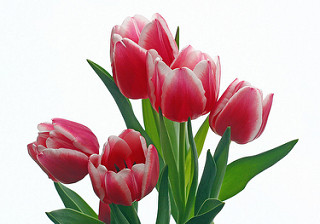

[[('n13133613', 'ear', 0.32741132),
  ('n07718747', 'artichoke', 0.09085885),
  ('n12144580', 'corn', 0.08646),
  ('n02219486', 'ant', 0.08295365),
  ('n07720875', 'bell_pepper', 0.080778874)]]

In [14]:
# Image of a tulip
display(Image(filename= pathTrain + 'tulips/2229804138_db9cba3443_n.jpg', width=200))
display(mobileClassifier('tulips/2229804138_db9cba3443_n.jpg', pathFolder=pathTrain, mobile=mobile))

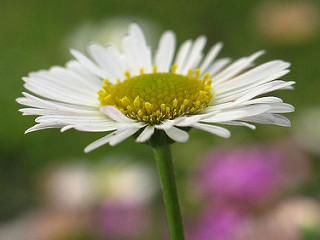

[[('n11939491', 'daisy', 0.998519),
  ('n02206856', 'bee', 0.00032603077),
  ('n01833805', 'hummingbird', 0.0002674477),
  ('n07730033', 'cardoon', 0.00022981566),
  ('n02219486', 'ant', 0.00010580722)]]

In [15]:
# Image of a daisy
display(Image(filename= pathTrain + 'daisy/5794835_d15905c7c8_n.jpg', width=200))
display(mobileClassifier('daisy/5794835_d15905c7c8_n.jpg', pathFolder=pathTrain, mobile=mobile))

#### Your comments here:


Having loaded images of various categories and having instructed MobileNet to classify the selected images, we can very clearly see that the classification performance is **not similar** across categories.

It seems like MobileNet is able to very accurately classify the daisy and the German Shepherd; meanwhile, MobileNet correctly classifies the Labrador retriever - albeit with a lot less confidence (as evident by the probability of around 0.36 that MobileNet has assigned) though we at least see that the other likely classes for the Labrador that MobileNet suggests are at least all dog breeds.

However, although I didn't choose particularly complex images, MobileNet fares very poorly when attempting to classify the rose and the tulip.

This is likely to be the case because MobileNet had been explicitly trained on classifying certain flowers and dogs (e.g. German Shepherds, daisies, and Labradors) but has not been trained on other images (e.g. tulips and flowers), as such the classifier is having a hard time trying to classify these images. Even in the case of the Labrador, perhaps it is that this image of a Labrador is sufficiently distinct from those that MobileNet had been trained on or that this image seems to resemble images of other similar dog breeds.

**1.2. [15pts]** Explore the feature maps extracted by the pre-train MobileNet. In particular, extract the features that MobileNet learns for three images, one from each category of dogs and flowers.
 
First, prepare the two images from each category

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


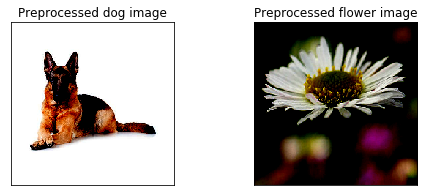

In [16]:
# Prepare two images by preprocessing them and display them here
prep_dog = prepare_image(pathTrain + 'German_Shepherd/35.german_shepherd.jpg')
prep_flo = prepare_image(pathTrain + 'daisy/5794835_d15905c7c8_n.jpg')
fig, ax = plt.subplots(1,2, figsize=(8, 3),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(prep_dog[0,:,:,:])
ax[0].set_title('Preprocessed dog image')
ax[1].imshow(prep_flo[0,:,:,:])
ax[1].set_title('Preprocessed flower image')
plt.show()

Inspect the first convolution layer: `conv1`. Exctract and plot the first five features maps of each image.

Hint: Load only up to the first convolution layer. Use `summary()` to check the name of the layer.


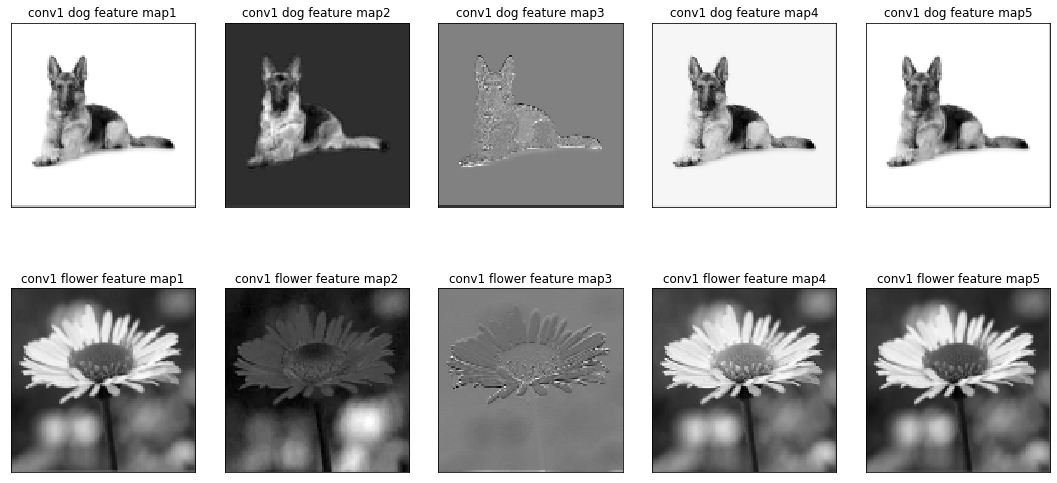

In [17]:
# Create temp model to return first convolution layer
conv1 = Model(inputs=mobile.input, outputs=mobile.get_layer('conv1').output)
fmap_dog = conv1.predict(prep_dog)
fmap_flo = conv1.predict(prep_flo)

# Plot the feature maps of the first convolutional layer
fig, ax = plt.subplots(2,5, figsize=(15,8),subplot_kw={'xticks': [], 'yticks': []})
for i in range(5):
    ax[0,i].imshow(fmap_dog[0,:,:,i], cmap='gray')
    ax[0,i].set_title('conv1 dog feature map'+ str(i + 1))
    ax[1,i].imshow(fmap_flo[0,:,:,i], cmap='gray')
    ax[1,i].set_title('conv1 flower feature map'+ str(i + 1))
plt.tight_layout()

Inpsect the last 2D convolution layer: `conv_pw_13`. Exctract and plot the first five features maps of each image.

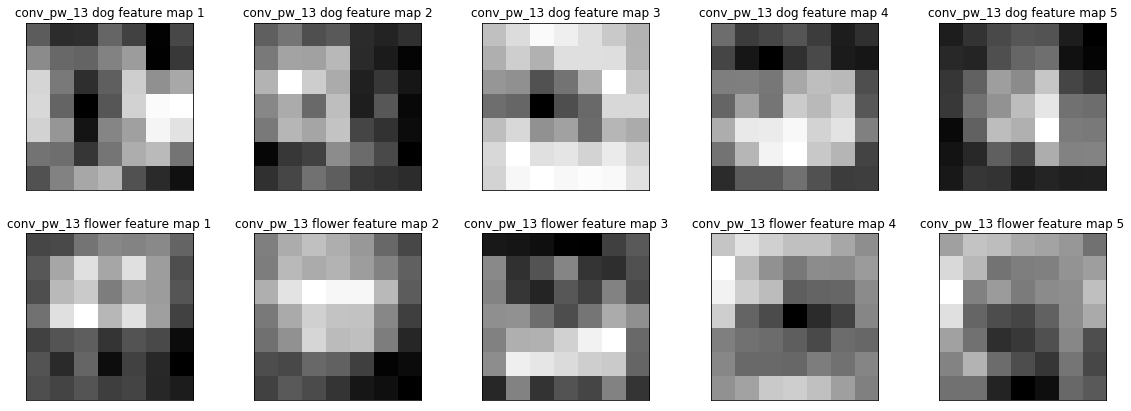

In [18]:
# Create temp model to return last convolution layer
conv13 = Model(inputs=mobile.input, outputs=mobile.get_layer('conv_pw_13').output)
fmap_dog = conv13.predict(prep_dog)
fmap_flo = conv13.predict(prep_flo)

# Plot the feature maps for the last convolutional layer
fig, ax = plt.subplots(2,5, figsize=(16,6),subplot_kw={'xticks': [], 'yticks': []})
for i in range(5):
    ax[0,i].imshow(fmap_dog[0,:,:,i], cmap='gray')
    ax[0,i].set_title('conv_pw_13 dog feature map ' + str(i + 1))
    ax[1,i].imshow(fmap_flo[0,:,:,i], cmap='gray')
    ax[1,i].set_title('conv_pw_13 flower feature map ' + str(i + 1))
plt.tight_layout()

Can we draw any conclusions or understand anything from these feature maps? Obviously no. It is a very abstract representation. We can further investigate the feature maps by using **Principal Component Analysis (PCA)** method.

**1.3. [15pts]** Use PCA to study the extracted feature maps. In particular, perform a PCA transform for the extracted from the last convolution layer features.

To save some time you might use only 20 images per category. These data are store at `pcaData`.


Define the layer from which we  extract the features

In [19]:
# Set our layer to be the last layer since that's where we are extracting the features
layer_extract = 'conv_pw_13_relu'

Two intermedia steps: (A)  Count the total images and the categories of the dataset that is located in the `pcaData` directory. (B)  Prepare the data for the PCA and assign the associate name of category of each image

In [20]:
# A: Count images in each cat, number of cats, total number of images

# Store categories and categories count
categories = os.listdir('data/pcaData/')
print("Number of categories: ", len(categories))

# Store image count and list of images
img_tot = 0
img_list = []
for cat in categories:
    print("Number of image in category {}: {}".format(cat, len(os.listdir('data/pcaData/' + cat))))
    img_tot += len(os.listdir('data/pcaData/' + cat))
    img_list = img_list + ['data/pcaData/' + cat + '/' + image for image in os.listdir('data/pcaData/' + cat)]
    
    #     img_list.append([dir for dir in os.listdir('data/pcaData/' + cat)])
    
print("Total number of images: ",img_tot)

Number of categories:  5
Number of image in category daisy: 20
Number of image in category German_Shepherd: 20
Number of image in category labrador: 20
Number of image in category rose: 20
Number of image in category tulips: 20
Total number of images:  100


In [21]:
# Create a temp model that returns us our final layer
tmp_model = Model(inputs=mobile.input, outputs=mobile.get_layer(layer_extract).output)

# Get the final layers from our temp model and preprocess images and store
pca_img = []
for img in img_list:
    pca_img.append(tmp_model.predict(prepare_image(img)))
    
f_maps = np.concatenate(pca_img, axis=0)
print("Shape of our tensor containing 100 feature maps", f_maps.shape)

Shape of our tensor containing 100 feature maps (100, 7, 7, 1024)


Perform PCA transform and keep only the first two principal components

In [22]:
# Flatten our feature maps so that they can be transformeed
all_maps = np.array([result.flatten() for result in f_maps])

# Perform a PCA transform with 2 components
pca_all_flat = PCA(n_components=2).fit_transform(all_maps)

Plot the results obtained by PCA transform. Use different color/symbol to represent each of the categories.

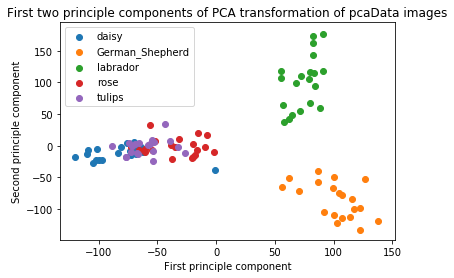

In [23]:
# Iterate over the number of classes and plot the scatters
for i in range(5):    
    plt.scatter(pca_all_flat[i*20 : (i+1)*20, 0], pca_all_flat[i*20 : (i+1)*20, 1],label=categories[i])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.title('First two principle components of PCA transformation of pcaData images')
plt.legend()
plt.show()

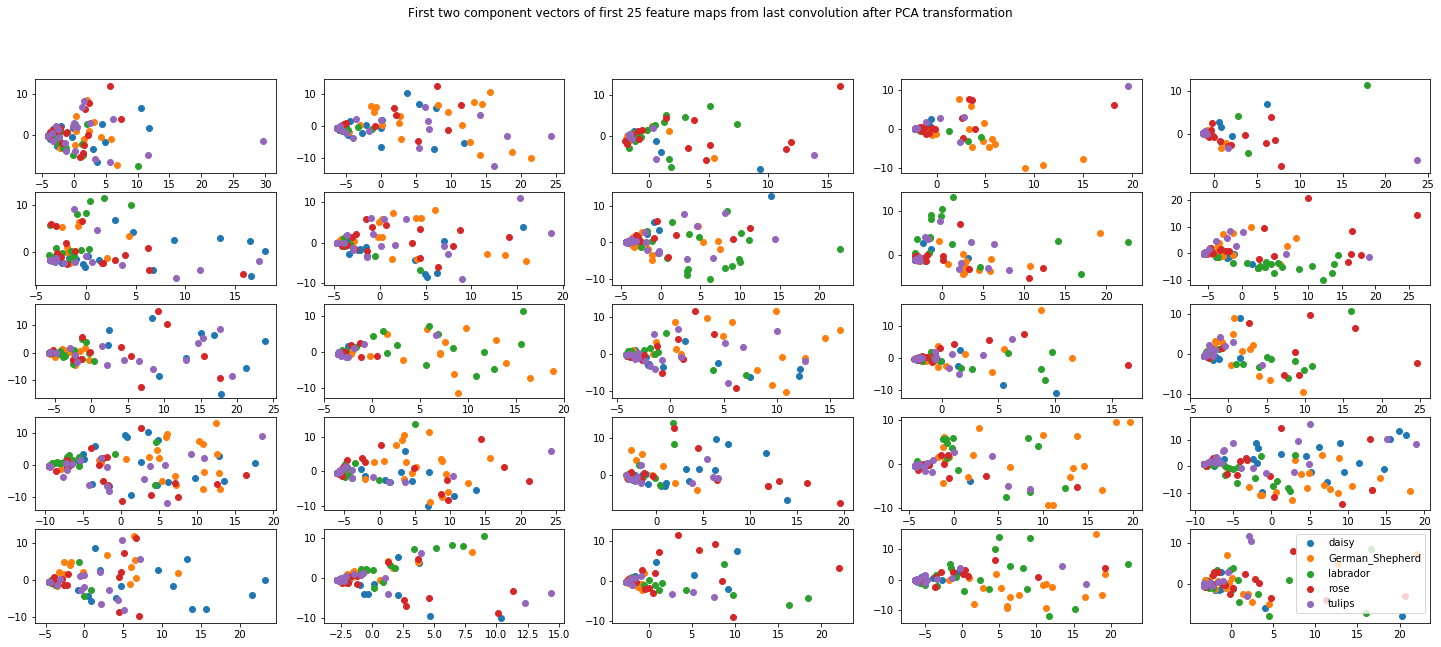

In [24]:
# Examine the first 25 feature maps
fig = plt.figure(figsize=(25, 10)) 
for k in range(25):    
    feature_map_k = np.array([result[:,:,k].flatten() for result in f_maps])
    pca_all_flat = PCA(n_components=2).fit_transform(feature_map_k)
    ax = plt.subplot(5, 5, k+1)
    for i in range(5):
        ax.scatter(pca_all_flat[i*20:(i+1)*20,0],pca_all_flat[i*20:(i+1)*20,1],label=categories[i])

plt.suptitle("First two component vectors of first 25 feature maps from last convolution after PCA transformation")
plt.legend();

#### Your comments here:


From our first plot, it is the case that dogs and flowers and clearly separated. Within the dogs, the German Shepherd and Labrador clusters are clearly separated; within the flowers, all three clusters seem to overlap to some degree and exhibit much less separability.  

Intuitively, this result makes sense because the result implies that dogs and flowers exhibit features that are very distinct from one another - and that the two dog breeds are distinct from the flowers and each other. In this sense, we might say that MobileNet is at least successful in differentiating between dogs and flowers and that the feature engineering/architecture is good at this classification. If it is the case that we are looking for a model that is able to make these more general classifications, we can use these results to say that MobileNet is up to the task.

Further, the plot seems to suggest that the flowers have similar features, but the overlap in the clusters on the initial PCA plot suggests that the model is not able to pick out features that enable it to clearly distinguish between the flowers - this aligns with our earlier result where we saw that the model failed to classify the daisy and the tulip. This result, could thus reflect how the model is not adequately trained on daisies and tulips - and as such, is not able to really distinguish them from each other or from other flowers. As such, for our model to classify flowers, it will need to either be trained more extensively on different flowers or have an architecture that is more suited to this task since. We can potentially look into training up the dense layers or the final few convolutional layers.

The plot also suggests that it is quite competent at distinguishing between Labradors and German Shepherds - though our earlier results seem to suggest that MobileNet is not great at identifying Labradors. This illustrates the limited utility of our plot because we really only have two classes of dogs in consideration here.

What the plot fails to explain is why it is the case that even though the Labrador's features seem so distinct and cleanly separable, the confidence of the prediction was so low. What is likely to be the case here is that even though Labradors are very separable from German Shepherds (potentially due to the sheer difference in the shade of their fur), it could be the case that Labradors share a lot of similar features with other dog breeds that make it more difficult to classify.

---

<div class='exercise'><b> Question 2: Improve the classification ability of the pre-trained MobileNet  [30pts total] </b></div>



How can we improve the MobileNet?

The pre-trained MobileNet architecture shows quite good performance. Nevertheless, we want to improve  its classification ability  on the class of flowers. 
Training the MobileNet from  scratch by using only images  for dogs and flowers  will be overfitting because our dataset is too small and the network very expressive. So, let's use *transfer learning*.

 Use the pre-trained model and re-train just a few layers (fast and efficient).
 Since the convolution layers of the MobileNet can extract  abstract features from the images we can use (transfer) this knowledge by  freezing the convolution pre-trained layers. In particular, we can adjust and train one or a few new layers to classify the new data from the extracted features


**2.1. [15pts] Add and train a new dense layer on the top of the pre-trained MobileNet**


Use all the pre-trained convolution layers obtained by MobileNet (`base` model) and adjust one new dense layer in the end (`head`). Then, freeze the base layers and train only the fully connected layer. 

Define the base model

In [117]:
# Define base model as MobileNet without top
base_model = MobileNet(input_shape=IMG_SHAPE, weights='imagenet',include_top=False)

# Number of layers in the base model
n_layers = len(base_model.layers)
print("No. of layers in the base model: ", n_layers)

# Set up dense layers for our output
# base_out = base_model.output
base_out = GlobalAveragePooling2D()(base_model.output)
base_out = Dense(1024, activation='tanh',
                 kernel_regularizer=keras.regularizers.l2(0.01),
                 activity_regularizer=keras.regularizers.l1(0.01))(base_out)
base_out = Dense(5,activation='softmax')(base_out) 

No. of layers in the base model:  87


Create the new architecture by transfering the convolutions layers from the MobileNet. The name of the new architecture should be  `mobile_tl`.


In [118]:
# Freeze base layers
mobile_tl = Model(inputs=base_model.input,outputs=base_out)
for layer in mobile_tl.layers[:-2]:
    layer.trainable = False
    
# Make sure final few are trainable
for layer in mobile_tl.layers[-2:]:
    layer.trainable = True
    print("Setting layer {} to be trainable".format(layer.name))
    
mobile_tl.summary()

Setting layer dense_24 to be trainable
Setting layer dense_25 to be trainable
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
______________________________________________

**2.2. [15pts] Compile the model and show the perfrormance of the new model**

Define an optimizer, the loss function, regularization, and the number of training period (epochs).  
To inspect the network performance after the training, you might store the Loss functions and the accuracy.
For the specific example, the validation loss should be less than 1 and the accuracy on the validation set should be at least 80%. A training between five and ten epochs should be fine.


In [119]:
# Compile model
mobile_tl.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Set up data generators
train_generator=train_datagen.flow_from_directory(pathTrain,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True, 
                                                 classes=listGroupsTrain)

test_generator=test_datagen.flow_from_directory(pathFolder+'testData',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 classes=listGroupsTest)

step_size = train_generator.n // train_generator.batch_size 
print('Train generator n: ', train_generator.n)
print('Train generator batch_size: ', train_generator.batch_size)
print('Step size: ', step_size)

Found 843 images belonging to 5 classes.
Found 160 images belonging to 5 classes.
Train generator n:  843
Train generator batch_size:  64
Step size:  13


In [122]:
%%time
verbose, epochs, batch_size = 1, 10, 128
callbacks = [keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            verbose=1)]

# Fit the model 
history = mobile_tl.fit_generator(generator=train_generator,
                                  validation_data=test_generator,
#                                   callbacks=callbacks, 
                                  steps_per_epoch=step_size, 
                                  epochs=epochs, 
                                  verbose= verbose)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 3 steps
Epoch 1/10
13/13 [==============================] - 28s 2s/step - loss: 4.2633 - accuracy: 0.9114 - val_loss: 4.2965 - val_accuracy: 0.7125
Epoch 2/10
13/13 [==============================] - 32s 2s/step - loss: 3.4352 - accuracy: 0.9294 - val_loss: 4.0867 - val_accuracy: 0.5437
Epoch 3/10
13/13 [==============================] - 27s 2s/step - loss: 3.1941 - accuracy: 0.8755 - val_loss: 5.3467 - val_accuracy: 0.6313
Epoch 4/10
13/13 [==============================] - 27s 2s/step - loss: 4.4161 - accuracy: 0.8588 - val_loss: 4.1509 - val_accuracy: 0.7812
Epoch 5/10
13/13 [==============================] - 29s 2s/step - loss: 3.6638 - accuracy: 0.8922 - val_loss: 3.0300 - val_accuracy: 0.8562
Epoch 6/10
13/13 [==============================] - 30s 2s/step - loss: 2.7475 - accuracy: 0.9207 - val_loss: 2.8708 - val_accuracy: 0.8375
Epoch 7/10
13/13 [==============================] - 32s 2s/step - los

Plot the loss and the accuracy for training and validation

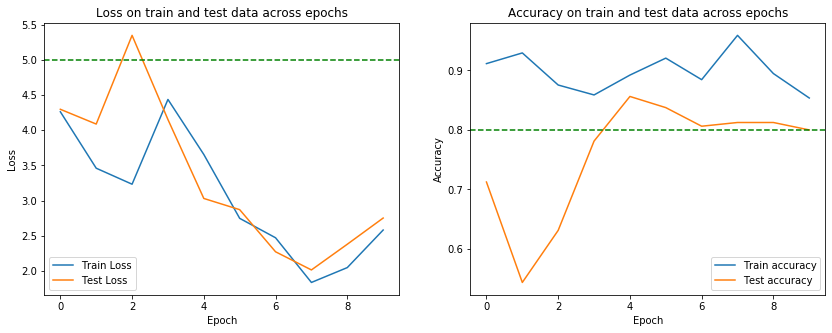

In [123]:
fig , ax = plt.subplots(1,2,figsize=(14,5))

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Test Loss')
ax[0].set_title('Loss on train and test data across epochs')
ax[0].axhline(5, c='green', linestyle='dashed')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='Train accuracy')
ax[1].plot(history.history['val_accuracy'], label='Test accuracy')
ax[1].axhline(0.8, c='green', linestyle='dashed')
ax[1].set_title('Accuracy on train and test data across epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend()
plt.show()

Our model achieves at least 80% validation accuracy and a loss of less than 5 on our test set.

The plots are as we would expect - the performance (loss and accuracy) on the train set is generally higher than in our test set. We also see that our model accuracy generally increases with each epoch and that the increase seems to be plateauing; similarly, the decrease in loss seems to be converging towards a minimum.

<div class='exercise'><b> Question 3: Improve the extraction of the feature maps [30pts total] </b></div>


**3.1. [pts 15] Fine Tuning**

Take the previous based model and unfreeze the convolution layers. Create a new model with the base model and with the dense layer used in the `model_tl`. Then, train the entire network. Name the new model as `mobile_tuned`.

In [124]:
# Redefine new model with unfrozen layers
mobile_tuned = mobile_tl
mobile_tuned.trainable = True
mobile_tuned.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128

**3.2. [15pts] Compile the model, present the perfrormance of the new model, and visualize the feature maps with PCA**


In [129]:
# Compile our model
mobile_tuned.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

verbose, epochs, batch_size = 1, 10, 128

# Fit our model 
history_tuned = mobile_tuned.fit_generator(generator=train_generator, 
                                  validation_data=test_generator, 
                                  steps_per_epoch=step_size,
                                  epochs=epochs,
                                  verbose= verbose)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 13 steps, validate for 3 steps
Epoch 1/10
13/13 [==============================] - 87s 7s/step - loss: 0.2018 - accuracy: 0.9949 - val_loss: 1.5034 - val_accuracy: 0.6938
Epoch 2/10
13/13 [==============================] - 82s 6s/step - loss: 0.1758 - accuracy: 0.9923 - val_loss: 0.9869 - val_accuracy: 0.7437
Epoch 3/10
13/13 [==============================] - 85s 7s/step - loss: 0.1589 - accuracy: 0.9936 - val_loss: 1.4483 - val_accuracy: 0.6313
Epoch 4/10
13/13 [==============================] - 83s 6s/step - loss: 0.1478 - accuracy: 0.9949 - val_loss: 1.6740 - val_accuracy: 0.6750
Epoch 5/10
13/13 [==============================] - 84s 6s/step - loss: 0.1381 - accuracy: 0.9949 - val_loss: 1.5806 - val_accuracy: 0.6687
Epoch 6/10
13/13 [==============================] - 83s 6s/step - loss: 0.1413 - accuracy: 0.9961 - val_loss: 1.0309 - val_accuracy: 0.8313
Epoch 7/10
13/13 [==============================] - 83s 6s/step - los

Visualize the performance (in comparison with the `mobile_tl`) and make some comments

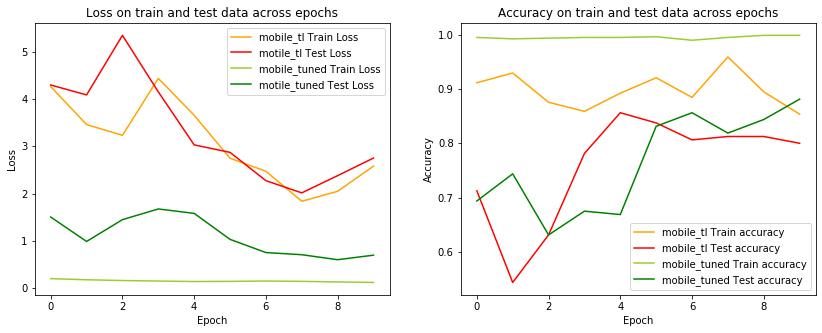

In [137]:
fig , ax = plt.subplots(1,2,figsize=(14,5))

ax[0].plot(history.history['loss'], label='mobile_tl Train Loss', c="orange")
ax[0].plot(history.history['val_loss'], label='motile_tl Test Loss', c="red")
ax[0].plot(history_tuned.history['loss'], label='mobile_tuned Train Loss', c="yellowgreen")
ax[0].plot(history_tuned.history['val_loss'], label='motile_tuned Test Loss', c="green")
ax[0].set_title('Loss on train and test data across epochs')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='mobile_tl Train accuracy', c="orange")
ax[1].plot(history.history['val_accuracy'], label='mobile_tl Test accuracy', c="red")
ax[1].plot(history_tuned.history['accuracy'], label='mobile_tuned Train accuracy', c="yellowgreen")
ax[1].plot(history_tuned.history['val_accuracy'], label='mobile_tuned Test accuracy', c="green")
ax[1].set_title('Accuracy on train and test data across epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend()
plt.show()

#### Your comments here:

As expected, this model takes substantially longer to train since we are training all the many laters. However, after the fine-tuning we observe that the model performance improves. 

Namely, on the train data (the orange and light green curves), the loss is noticeable lower throughout all epochs for our fine-tuned model compared to our mobile_tl model; also, the accuracy of our fine-tuned model is consistently higher than that of our mobile_tl model. 

Meanwhile, on the test (validation) data (the red and dark green curves), the loss in our fine-tuned model is also consistently lower than in our mobile_tl model; the test accuracy of mobile_tuned initially starts off worse, but achieves higher and more consistently high validation accuracy than our mobile_lt model.

**Investigate the feature extraction by using PCA**

In [140]:
# Set our layer to be the last layer since that's where we are extracting the features
layer_extract = 'conv_pw_13_relu'

# Create a temp model that returns us our final layer
tmp_model = Model(inputs=mobile_tuned.input, 
                  outputs=mobile_tuned.get_layer(layer_extract).output)

# Get the final layers from our temp model and preprocess images and store
pca_img = []
for img in img_list:
    pca_img.append(tmp_model.predict(prepare_image(img)))

f_maps = np.concatenate(pca_img, axis=0)    
print("Shape of our tensor containing 100 feature maps", f_maps.shape)

# Flatten our feature maps so that they can be transformed
all_maps = np.array([result.flatten() for result in f_maps])

# Perform a PCA transform with 2 components
pca_all_flat = PCA(n_components=2).fit_transform(all_maps)

Shape of our tensor containing 100 feature maps (100, 7, 7, 1024)



Visualize the results obtained by PCA

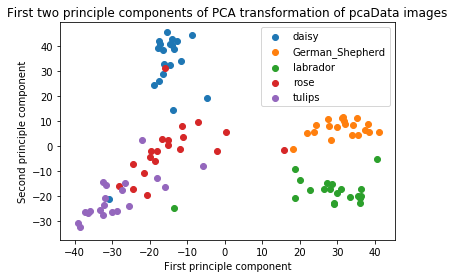

In [142]:
# Iterate over the number of classes and plot the scatters
for i in range(5):    
    plt.scatter(pca_all_flat[i*20 : (i+1)*20, 0], pca_all_flat[i*20 : (i+1)*20, 1],label=categories[i])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.title('First two principle components of PCA transformation of pcaData images')
plt.legend()
plt.show()

Make some comments

#### Your comments here:


Evidently, the scale of the the PCA scatterplot above is different, but it is sufficient to see that in our fine-tuned model, we see a dramatic improvement in the clustering of the flowers - we see much less overlapping clusters between flowers. Daisy is largely it's own cluster; tulipds and roses are somewhat overlapping, but to a far smaller extent than previously; meanwhile, German Shepherds and Labradors have their own distinct clusters - though several outliers (rose and labrador) exist.

Thus, we see much better class separation after fine-tuning our model - but we do not see perfect separation (and we see quite a few 'outliers' or stragglers i.e. points with low cluster cohesion) and this is likely to be the case because our dataset that we fine-tuned our model on is small.

## **References**

- https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299
- https://towardsdatascience.com/review-mobilenetv1-depthwise-separable-convolution-light-weight-model-a382df364b69
- https://www.alibabacloud.com/blog/part-3-image-classification-using-features-extracted-by-transfer-learning-in-keras_595291
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://arxiv.org/abs/1704.04861    

